<a href="https://colab.research.google.com/github/mistryvivek/YRKCS-PRBX/blob/main/PADL_Week_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practical week 9: custom data loaders, a CNN from scratch and visualising loss curves

The practical this week focusses on some low level practical issues that you will need to tackle in the assessment. We will see how to take an arbitrary dataset and write a custom data loader so that we can request random mini-batches during training like we did last week. Then you'll design and train your own CNN to learn a classification problem on the data. Working through this whole practical is great practice for the assessment.

##This week's dataset

The task this week is to classify clothing images according to the type of garment. For this task, we're using the Fashion MNIST dataset. It's exactly the same format as the MNIST digits dataset we used last week (60k training images, 10k test images, 10 possible class labels, grayscale images of size $28\times 28$). See the code below for descriptions of the 10 classes.

Fashion MNIST is already set up as a dataset in PyTorch. However, we're going to pretend it's not so that you can experience writing your own custom data loader.

The following code will download and uncompress the training and testing datasets, then load them as PyTorch tensors. You'll have to do the rest.

In [ ]:
import torch
import os
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import math
import matplotlib.pyplot as plt

classes = ['T-shirt/top',
           'Trouser',
           'Pullover',
           'Dress',
           'Coat',
           'Sandal',
           'Shirt',
           'Sneaker',
           'Bag',
           'Ankle boot']
datafolder = 'fashion-mnist/'
os.makedirs(datafolder,exist_ok=True)

url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
files = ['train-images-idx3-ubyte','train-labels-idx1-ubyte','t10k-images-idx3-ubyte','t10k-labels-idx1-ubyte']
for f in files:
  datasets.utils.download_and_extract_archive(url+f+'.gz',datafolder)
data_train = datasets.mnist.read_image_file(datafolder+files[0])
labels_train = datasets.mnist.read_label_file(datafolder+files[1])
data_test = datasets.mnist.read_image_file(datafolder+files[2])
labels_test = datasets.mnist.read_label_file(datafolder+files[3])

The raw data is now loaded into tensors. Let's check we're happy with the shapes and contents.

In [ ]:
print('TRAINING DATA')
print(data_train.shape)
print('Minimum value: {}'.format(data_train.min()))
print('Maximum value: {}'.format(data_train.max()))
print(data_train.dtype)
print('TRAINING LABELS')
print(labels_train.shape)
print('Minimum value: {}'.format(labels_train.min()))
print('Maximum value: {}'.format(labels_train.max()))

Do the shapes of the two tensors make sense to you? One important note: we're storing the images currently as 8 bit integers to save space but we'll need to switch to floats for each mini-batch for training.

##Custom data loaders

`torch.utils.data.Dataset` is an abstract class for representing a dataset. To write a custom data loader you need to inherit `Dataset` and override two methods:

- `__len__` such that `len(dataset)` returns the number of elements in the dataset
- `__getitem__` such that `dataset[i]` can be used to get the $i$th element from the dataset

You can use the `__init__` constructor to set up your data. There are two common ways of constructing a data loader:

1. Read the entire dataset into memory inside `__init__`. If the dataset isn't too big so that you can hold the whole thing in memory then this is a good idea since `__getitem__` won't need to read anything from disc. (This option is fine for the dataset in this practical).
2. For larger datasets, `__init__` is just used to initialise where the dataset is stored and perhaps to read the labels into memory but no actual input data is loaded at this point. Then when `__getitem__` is called you actually load that specific item (for example an image) from disc.

Anything that `__len__` or `__getitem__` need access to should be stored in `self`.

**To do**:

Create a custom dataset whose constructor takes as input a size $n\times 28 \times 28$ tensor of images and size $n$ tensor of class labels. `__getitem__` should return a single image of size $1\times 28 \times 28$ as a 32 bit float scaled between 0 and 1 (hint: `x.float()/255` converts `x` from 8 bit integers to 0..1 floats) and the corresponding class label.

In [ ]:
class FashionMNISTDataset(Dataset):
  """Custom Fashion MNIST dataset."""

  def __init__(self, data, labels):
    # Your code goes here

  def __len__(self):
    # Your code goes here

  def __getitem__(self, idx):
    # Your code goes here
    return image, label

train_data = FashionMNISTDataset(data_train,labels_train)
test_data = FashionMNISTDataset(data_test,labels_test)

Let's test whether your dataset is behaving as expected.

In [ ]:
image, label = train_data[0]
print(image.shape) # should be 1 x 28 x 28

Now we can create dataloaders from your two datasets.

In [ ]:
batch_size=100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

Let's test them. Do these sizes look right?

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

##Visualising the dataset

**To do**:

Look at last week's practical and copy the code for visualing images from a mini-batch. Run it with your dataloader to inspect the data. Now modify it so that it prints class descriptions as given above rather than class IDs.

##Create a CNN

**To do**:

Now create a CNN to try to solve this classification problem. You could use the LeNet architecture from the last practical, the mini VGG I gave in my model solution or invent your own from scratch. Maybe you want to try batchnorm layers or even a residual block.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Your code goes here...

    def forward(self,x):
        # Your code goes here...

# Instantiate the model - this initialises all weights and biases
model = CNN()

# Decide what loss function to use
#loss_func = ...

It's interesting to see how many learnable parameters your model has in total:

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

Let's put a mini-batch through your CNN, compute a loss and check everything looks ok.

In [ ]:
images, labels = next(iter(train_loader))
output = model(images)
print(output.shape)
loss = loss_func(output,labels)
print(loss)

##Visualisation and training

It's time to train your network. But this time we are going to visualise loss at every iteration and classification accuracy at every epoch for both the training and testing sets. Run the code below then execute the code cell underneath to plot the training curves.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

num_epochs = 20

# Set up the optimiser
optim = torch.optim.Adam(model.parameters(), lr = 0.1)

# Initialise some variables for computing and tracking stats
iterations_per_epoch = math.ceil(len(train_data)/batch_size)
training_losses = []
training_accuracies = []
testing_losses = []
testing_accuracies = []
for epoch in range(num_epochs):

  # One epoch on the training set
  total_loss = 0
  correct = 0
  total = 0
  total_loss = 0
  for i, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    output = model(inputs)
    loss = loss_func(output,labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    pred_y = torch.argmax(output, 1)
    correct += (pred_y == labels).sum()
    total += float(labels.size(0))
    total_loss += loss*inputs.shape[0]
    if (i+1) % 100 == 0:
       print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
  total_loss /= len(train_data)
  training_losses.append(total_loss.item())
  training_accuracies.append((correct/total).cpu())
  print('Train accuracy over epoch {}: {:.4f}'.format(epoch+1,training_accuracies[-1]))

  # One epoch on the test set
  correct = 0
  total = 0
  total_loss = 0
  # Switch to evaluation mode
  model.eval()
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      output = model(inputs)
      loss = loss_func(output,labels)
      pred_y = torch.argmax(output, 1)
      correct += (pred_y == labels).sum()
      total += float(labels.size(0))
      total_loss += loss*inputs.shape[0]
    test_accuracy = correct/total
  total_loss /= len(test_data)
  testing_losses.append(total_loss.item())
  # Switch back to training mode
  model.train()
  testing_accuracies.append(test_accuracy.cpu())
  print('Test accuracy at epoch {}: {:.4f}'.format(epoch+1,test_accuracy))

In [ ]:
plt.title("Training curve")
plt.plot(range(len(training_losses)),training_losses,'r')
plt.plot(range(len(testing_losses)),testing_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.title("Classification accuracy")
plt.plot(range(len(training_accuracies)),training_accuracies,'r')
plt.plot(range(len(testing_accuracies)),testing_accuracies,'g')
plt.xlabel("Epoch")
plt.ylabel("Classification accuracy")
plt.show()

What do you make of the plots? Has training converged yet? Is your model too powerful? (i.e. is overfitting happening?) Or not powerful enough? (Performance not improving much). Tweak your model or hyperparameters if you think there's a problem.

**To do**:

- Try plotting training loss at every iteration rather than just every epoch. Why does it look so different?
- Reuse the visualisation code from last week to show example images along with their correct/estimate class.
- You've probably noticed that training is starting to take a while. Try switching to using a GPU (see lecture slides for instructions).




##Implement a ResNet (optional)

Take any of the problems you've worked on over the past couple of weeks (e.g. MNIST digit or fashion classification) and try implementing your own resnet architecture to solve it. Usually, this would start with a convolutional layer to transform from the one input channel to some larger number of features then residual blocks which contain a number of convolutional layers applied in sequence. You might like to define a residual block as its own `nn.Module` then you can define your network using `nn.Sequential` including your new blocks. Instead of pooling, it is more common to use strided convolutions. Also, instead of fully connected layers at the end, it is more common to use global average pooling (i.e. pooling with kernel size equal to spatial dimensions). If your residual block changes the size of tensor either spatially or in number of channels, then you need to apply some kind of downsampling to the residual connection. How does your model compare to the other networks we tried?

##An extra challenge: fully convolutional LeNet

If you would like an extra challenge to work on, try this...

As was pointed out in [this paper](https://arxiv.org/pdf/1605.06211.pdf), a CNN that includes fully connected layers can be thought of as having only convolution layers. The fully connected layers are just a special case where the filter size is $1\times 1$. Start by training a modified version of LeNet in which you replace the fully connected (i.e. `torch.nn.Linear`) layers with convolutions. To do this you need to:

1. Delete the flattening operation in the forward pass (that reshapes from $B\times 16 \times 5 \times 5$ to $B\times 400$).
2. In the original LeNet, the second convolution uses no padding which shrinks the feature map by two pixels vertically and horizontally. This is undesirable for a fully convolutional network as it means regions at the boundary are treated differently. So, let's scrap that and use `padding=2` like in the first convolution layer.
3. The first linear layer should be replaced by a convolution. Originally, the feature map at this point would have size $5\times 5$ but because we just added padding, it will now have size $7\times 7$. So, for this new convolution layer use kernel size $7\times 7$ and no padding. We also want to only consider each region independently and not the overlaps between them so set `stride=7`. This is now exactly equivalent to flattening followed by a fully connected layer. It's a special case where the filter exactly spatially covers the input. The output size of this tensor will be $B\times 120 \times 1 \times 1$, i.e. it has spatial size $1\times 1$ and 120 channels.
4. The second and third linear layers should be replaced with convolution layers with kernel size $1\times 1$ and no padding and the appropriate number of input and output channels.
5. The final output will now have size $B\times 10 \times 1 \times 1$. Before passing to the loss function, you need to squeeze to size $B\times 10$.

You can now train the model exactly as before. However, once trained, you should be able to input images with size different to $28\times 28$. The output will no longer have size $10\times 1\times 1$. For example, if you input an image of size $56\times 56$, the output will be size $10\times 2\times 2$. At each of the four locations, you will get 10 values related to how likely it thinks each digit is at that location.

Download the following image:

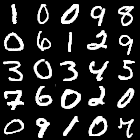

Upload it to your notebook's session storage and load it. The recommended way to read images is using `PIL.Image`. The torchvision transform `ToTensor` will convert this to a PyTorch tensor. E.g. see the following example:

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.ToTensor()
im = transform(Image.open('filename.png'))
# im is now a C x H x W PyTorch tensor

Pass the image through your trained network. Apply softmax to the output to convert to probabilities. Now visualise the output as $5\times 5$ heat maps. For example, try visualising the first channel (representing the probability of a 0 digit). Do you see large probability where the zeros in the image are?